# Random initial access for mmWave networks

Flavien Solt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hadamard
from tqdm import tqdm_notebook as tqdm

# Number of possible beam directions
N_bs = 10 # unitless
N_ue = 10 # unitless

# Number of antennas
M_bs = 10
M_ue = 10

fc = 28e9 # Hz
light_speed = 299792458 # m/s

alpha_city = 3.5 # No unit

## Beamforming implementations

In [2]:
# Performs the f function of papier_wireless page 7
def beamforming_f(k, K, theta):
    denominator = np.array([[np.e**(i*1j*np.pi*np.sin(theta)) if i < k else 0] for i in range(K)]).conj()
    return denominator / np.sqrt(k)

beamforming_f = np.vectorize(beamforming_f)

# Performs the a function of papier_wireless page 7
def ULA_a(k, K, theta):
    denominator = np.array([[np.e**(i*1j*np.pi*np.sin(theta))] for i in range(k)]).conj()
    return denominator / np.sqrt(k)

In [3]:
def channel_C(xi_norm):
    return light_speed / (4*np.pi*xi_norm*fc)

# @param alpha is chosen in function of LOS communication or not
def channel_l(xi_norm, alpha):
    return channel_C(xi_norm)**alpha
    
def channel_h_ub():
    return np.random.rayleigh()

# @param alpha is chosen in function of LOS communication or not
def channel_H_ub(xi_norm, alpha, phi, k):
    return np.sqrt(channel_l(xi_norm, alpha))*channel_h_ub()*ULA_a(k, M_ue, 0)*(ULA_a(k, M_bs, phi).conj().T)

In [4]:
# Page 10

# Theta is always set to zero, since all depends on the angle difference

def link_budget(v, w, xi_norm, alpha, phi, k):
    return abs(np.dot(w.conj().T, np.dot(channel_H_ub(xi_norm, alpha, phi, k), v))[0][0])
    
def draw_link_budget_for_all_angles(v, w, distance, alpha, phis):
    k = len(phis)
    
    X = np.linspace(0, 2*np.pi, k) # Angle difference
    Y = [link_budget(v, w, distance, alpha, phis[i], k) for i in tqdm(range(k))]

    plt.title("Gain in function of the relative angle for the first precoding vectors")
    plt.xlabel("Relative angle")
    plt.ylabel("Gain")
        
    plt.plot(X, Y)
    
    plt.savefig('ula_first_precoding_vector.png', dpi=300)

In [5]:
# Generate the precoding vectors
def generate_precoding_vectors(angles, K):
    k = len(angles)
    return np.array([beamforming_f(k, K, angles[i]) for i in range(len(angles))])

In [6]:
k = 50
K = 10
distance = 11.3

thetas = np.linspace(0, 2*np.pi, k)
phis = np.linspace(0, 2*np.pi, k)

vs = generate_precoding_vectors(np.linspace(0, 2*np.pi, k), k)
ws = generate_precoding_vectors(np.linspace(0, 2*np.pi, k), k)

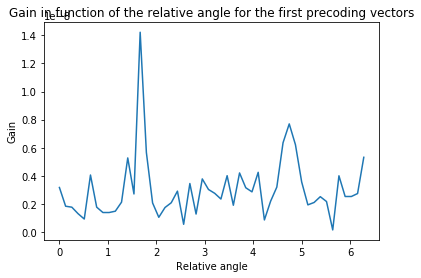

In [7]:
draw_link_budget_for_all_angles(vs, ws[0], distance, alpha_city, phis)

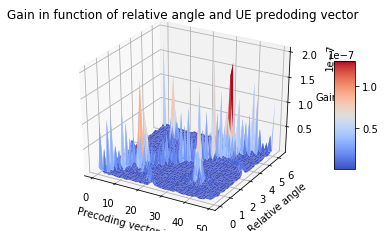

In [8]:
def draw_link_budget_for_all_angles_and_precoding_vectors(vs, w, distance, alpha, phis):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    theta_max = 2*np.pi

    X, Y = np.meshgrid([i for i in range(len(vs))], phis)

    Z = np.zeros(shape=(len(vs), len(phis)))

    for i in tqdm(range(len(vs))):
        for j in range(len(phis)):
            Z[i][j] = link_budget(vs[i], w, distance, alpha, phis[j], k)

    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=True)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('Precoding vector index')
    ax.set_ylabel('Relative angle')
    ax.set_zlabel('Gain')
    ax.set_title('Gain in function of relative angle and UE predoding vector')

    plt.savefig('ula_relative_angle_precoding_vector.png', dpi=300)
    
draw_link_budget_for_all_angles_and_precoding_vectors(vs, ws[0], distance, alpha_city, phis)

## Simulation on a random disk

### Method

The BS is considered alone at the origin of the plane, and the cell radius is fixed to 100m. The UE randomly drops within the cell.

We consider the article: 
_M. R. Akdeniz et al., “Millimeter wave channel modeling and cellular
capacity evaluation,” IEEE J. Sel. Areas Commun., vol. 32, no. 6,
pp. 1164–1179, Jun. 2014._:
This article gives us a real-life experimented formula for path loss.

No outage is supposed possible in this simulation. No interference from other cells. No collisions in the uplink either.

### Simulation

In [9]:
r_cell = 100 # m
sidecut = 10

# @param R the radius of the disk
# @param r the distance of the point to the center
# @return the density function evaluated in r
def disk_cdf(r, R):
    if r < 0:
        return 0
    return min(r*r/(R*R), 1)

def disk_cdf_recipr(proba, R):
    if proba <= 0:
        return 0
    return np.sqrt(proba)*R

# Simulates random UE position on disk
# @return the tuple (angle, distance) for a newly randomly uniformly generated point on the disk 
def simulate_random_on_disk(R):
    return np.random.uniform(high=2*np.pi), disk_cdf_recipr(np.random.uniform(), R)

# Exhaustive search on disk

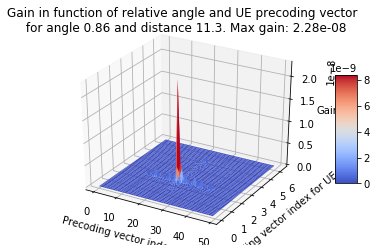

In [10]:
random_angle, random_distance = simulate_random_on_disk(r_cell)

def draw_link_budget_for_exhaustive_search(vs, ws, distance, alpha, phi):
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    from matplotlib import cm
    from matplotlib.ticker import LinearLocator, FormatStrFormatter

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    theta_max = 2*np.pi

    X, Y = np.meshgrid([i for i in range(len(vs))], phis)

    Z = np.zeros(shape=(len(vs), len(phis)))

    maxGain = 0
    for i in tqdm(range(sidecut, len(vs)-sidecut)):
        for j in range(sidecut, len(ws)-sidecut):
            Z[i][j] = link_budget(vs[i], ws[j], distance, alpha, phi, k)
            maxGain = max(Z[i][j], maxGain)
            
            
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=True)

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    ax.set_xlabel('Precoding vector index for BS')
    ax.set_ylabel('Precoding vector index for UE')
    ax.set_zlabel('Gain')
    ax.set_title('Gain in function of relative angle and UE precoding vector \n for angle {:.2f} and distance {:.1f}. Max gain: {:.3}'.format(phi, distance, maxGain))

    plt.savefig('ula_exhaustive_precoding.png', dpi=300)
        
draw_link_budget_for_exhaustive_search(vs, ws, distance, alpha_city, random_angle)


Average max gain for exhaustive search: 1.04e-09


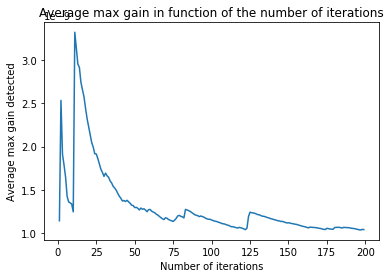

In [11]:
nb_samples_maxgain = 200

def get_maxgain_exhaustive(vs, ws, distance, alpha, phi):
    maxGain = 0
    for i in range(sidecut, len(vs)-sidecut):
        for j in range(sidecut, len(ws)-sidecut):
            maxGain = max(link_budget(vs[i], ws[j], distance, alpha, phi, k), maxGain)    
    return maxGain

def print_cumulated_max_gains_average(vs, ws, alpha, nb_samples):

    X = [i for i in range(nb_samples)]
    Y = [0 for x in X]

    avg_maxGain = 0
    for i in tqdm(range(nb_samples)):
        random_angle, random_distance = simulate_random_on_disk(r_cell)
        avg_maxGain += get_maxgain_exhaustive(vs, ws, random_distance, alpha, random_angle)
        Y[i] = avg_maxGain/(i+1)
        
    plt.title("Average max gain in function of the number of iterations")
    plt.xlabel("Number of iterations")
    plt.ylabel("Average max gain detected")
        
    plt.plot(X[1:], Y[1:])
    
    plt.savefig('ula_exhaustive_average_maxgain.png', dpi=300)
    return Y[-1]
    
avg_maxGain = print_cumulated_max_gains_average(vs, ws, alpha_city, nb_samples_maxgain)
print("Average max gain for exhaustive search: {:.3}".format(avg_maxGain))

# Random beamforming search on disk

[ 7 15 13  5 14 24 25 27 18 28  8 11 29 16  1  4 26 10  2  9  6  0 21  3
 17 20 23 12 19 22]


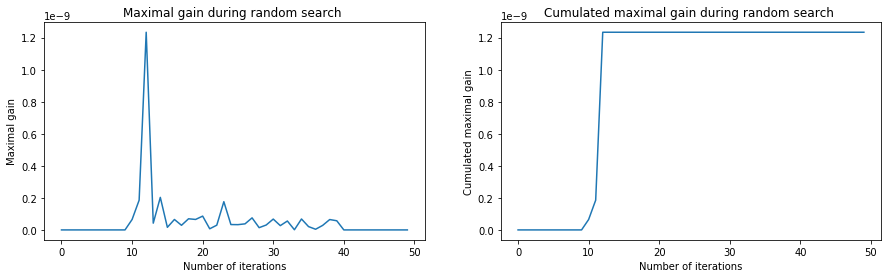

In [12]:
def draw_cumulated_maxGain_for(vs, ws, distance, alpha, phi):

    X = [i for i in range(len(vs))]
    Y = [0 for i in range(len(vs))]
    Y_cumulated = [0 for i in range(len(vs))]
    
    order = np.random.permutation(len(vs)-2*sidecut)
    print(order)
    
    cumulatedMax = 0    
    for i in tqdm(range(len(order))):
        localMaxGain = max(link_budget(vs[order[i]+sidecut], ws[j], distance, alpha, phi, k) for j in range(len(ws)))
        Y[sidecut+i] = localMaxGain
        cumulatedMax = max(localMaxGain, cumulatedMax)
        Y_cumulated[sidecut+i] = cumulatedMax
        
    for i in range(len(vs)-sidecut, len(vs)):
        Y_cumulated[i] = cumulatedMax
        
    plt.figure(figsize=(15,4))
    plt.subplot(1, 2, 1)
        
    plt.title("Maximal gain during random search ")
    plt.xlabel("Number of iterations")
    plt.ylabel("Maximal gain")
    
    plt.plot(X, Y)
    
    plt.subplot(1, 2, 2)
    plt.title("Cumulated maximal gain during random search ")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cumulated maximal gain")

    plt.plot(X, Y_cumulated)
    
    plt.savefig('ula_random_precoding.png', dpi=300)

random_angle, random_distance = simulate_random_on_disk(r_cell)
draw_cumulated_maxGain_for(vs, ws, random_distance, alpha_city, random_angle)